In [1]:
import json

from matplotlib import pyplot as plt
import numpy as np
import pdal
import pyproj
import rasterio
import rasterio.plot


IN_FILE = r'../datasets/01ID7913_proj.las'
# 静岡県のEPSGコード
IN_EPSG = 'EPSG:6669'
proj_crs = pyproj.CRS(IN_EPSG)
IN_SRS = proj_crs.to_wkt(pretty=True)

In [19]:
INTENSITY_PATH = IN_FILE.replace('proj.las', 'INTENSITY.tif')
RED_PATH = IN_FILE.replace('proj.las', 'RED.tif')
GREEN_PATH = IN_FILE.replace('proj.las', 'GREEN.tif')
BLUE_PATH = IN_FILE.replace('proj.las', 'BLUE.tif')

RESOLUTION = 0.5
_16bit = 2 ** 16


def output_dict(file_name, column):
    dic = {
        # Insensity（反射強度）の画像を出力
        'type': 'writers.gdal',
        'filename': file_name,
        'dimension': column,
        'data_type': 'uint8',
        'resolution': RESOLUTION,
        'output_type': 'mean',
        'nodata': 0,
        'default_srs': IN_SRS,
        'gdaldriver':'GTiff'
    }
    return dic

workflow = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': IN_FILE
        },
        {
            # '.las'に記録されているRGBが16bitなのでここで8bitに直す
            'type': 'filters.assign',
            'value': [
                f'Red = Red / {_16bit} * 255',
                f'Green = Green / {_16bit} * 255',
                f'Blue = Blue / {_16bit} * 255',
            ]
        },
        output_dict(INTENSITY_PATH, 'Intensity'),
        # Redの画像を出力
        output_dict(RED_PATH, 'Red'),
        # Greenの画像を出力
        output_dict(GREEN_PATH, 'Green'),
        # Blueの画像を出力
        output_dict(BLUE_PATH, 'Blue'),
    ]
}
pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()

6684581

In [30]:
intensity_dst = rasterio.open(INTENSITY_PATH)

red_dst = rasterio.open(RED_PATH)

green_dst = rasterio.open(GREEN_PATH)

blue_dst = rasterio.open(BLUE_PATH)

In [31]:
raster = np.array([
    red_dst.read(1),
    green_dst.read(1),
    blue_dst.read(1),
])

print(raster.shape)

(3, 1501, 2001)


In [22]:
img = np.dstack(raster)

print(img.shape)

(1501, 2001, 3)


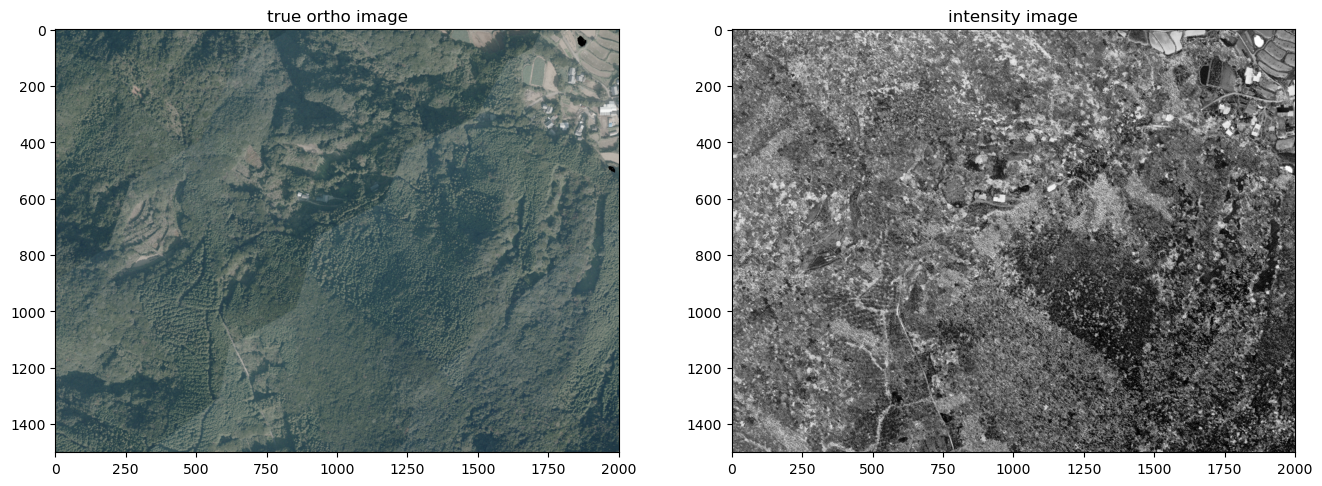

In [23]:
img = np.dstack(raster)

fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ax[0].set_title('true ortho image')
ax[0].imshow(img)
ax[1].set_title('intensity image')
ax[1].imshow(intensity_dst.read(1), cmap='Grays');

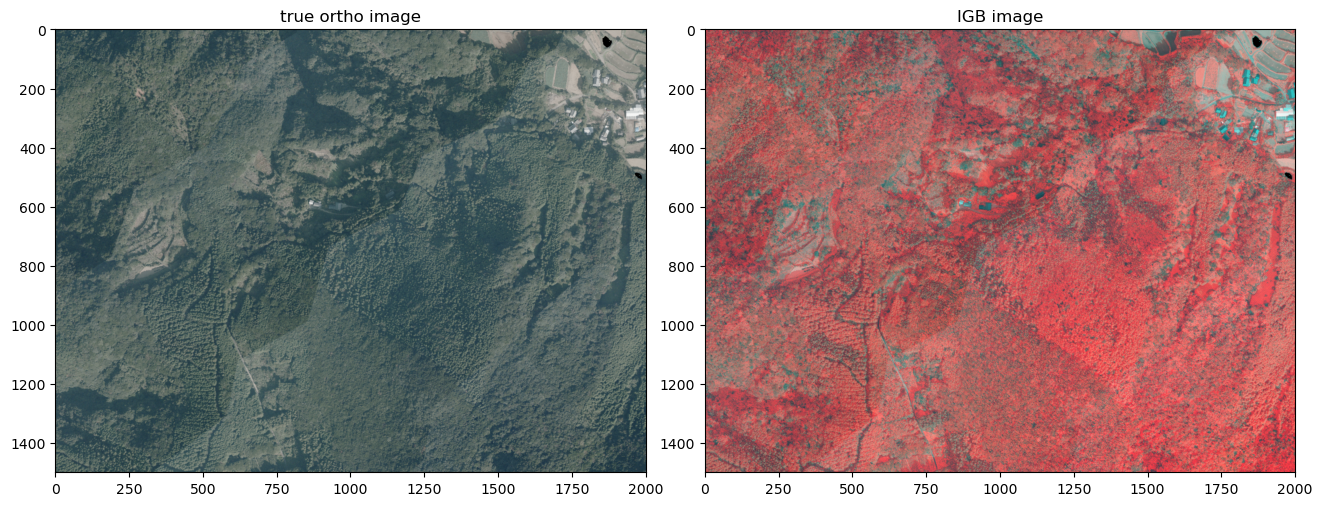

In [24]:
igb_img = np.dstack([
    intensity_dst.read(1),
    green_dst.read(1),
    blue_dst.read(1),
    
])


fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ax[0].set_title('true ortho image')
ax[0].imshow(img)
ax[1].set_title('IGB image')
ax[1].imshow(igb_img)
plt.subplots_adjust(wspace=0.1)

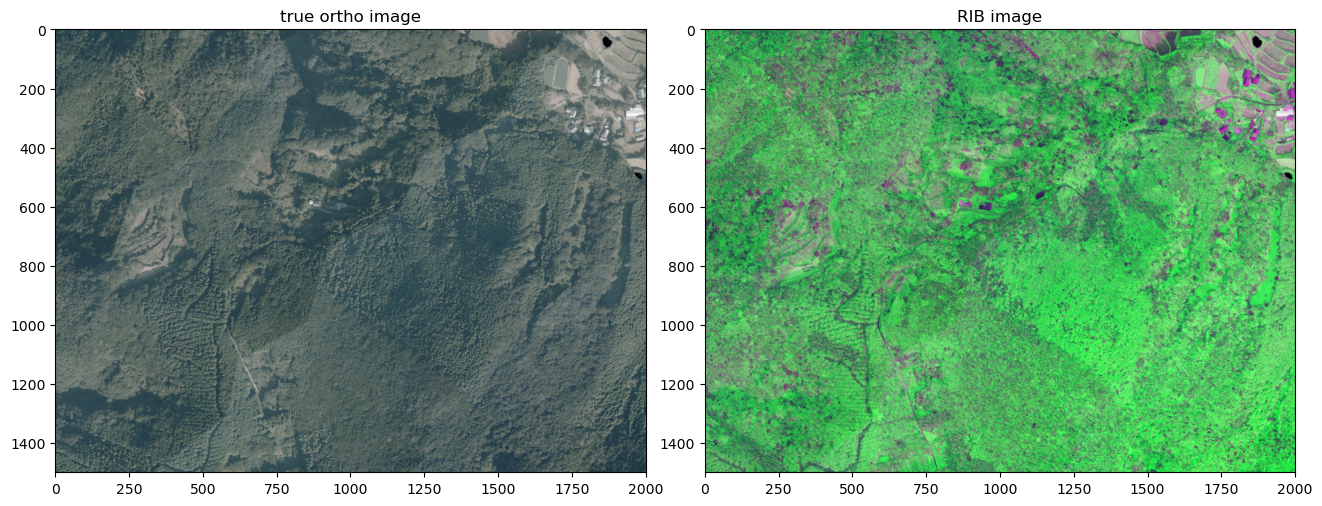

In [25]:
rib_img = np.dstack([
    red_dst.read(1),
    intensity_dst.read(1),
    blue_dst.read(1),
])

fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ax[0].set_title('true ortho image')
ax[0].imshow(img)
ax[1].set_title('RIB image')
ax[1].imshow(rib_img)
plt.subplots_adjust(wspace=0.1);

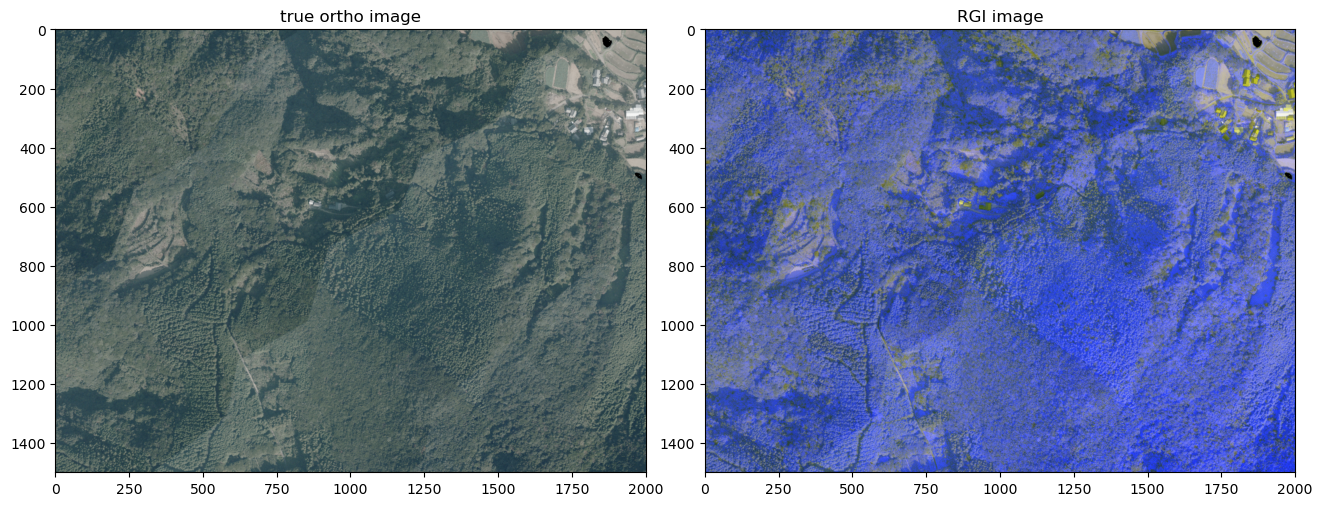

In [26]:
rgi_img = np.dstack([
    red_dst.read(1),
    green_dst.read(1),
    intensity_dst.read(1)
])

fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ax[0].set_title('true ortho image')
ax[0].imshow(img)
ax[1].set_title('RGI image')
ax[1].imshow(rgi_img)
plt.subplots_adjust(wspace=0.1)

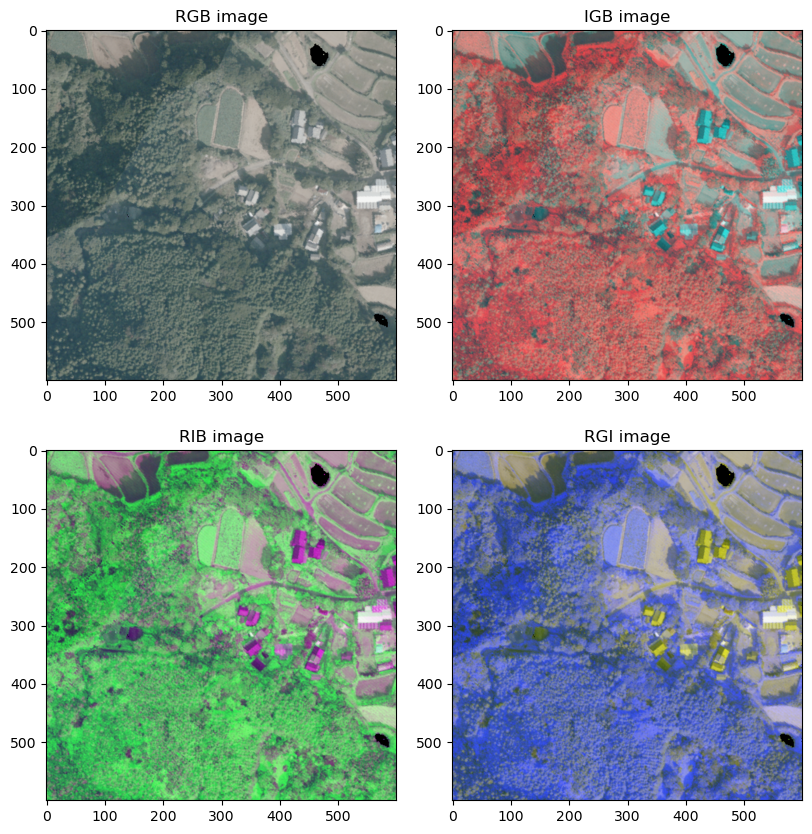

In [27]:
titles = [
    'RGB image',
    'IGB image',
    'RIB image',
    'RGI image'
]
arys = [
    img[: 600, 1401:, :],
    igb_img[: 600, 1401:, :],
    rib_img[: 600, 1401:, :],
    rgi_img[: 600, 1401:, :]
]

fig = plt.figure(figsize=(10, 10))
for idx, (title, ary) in enumerate(zip(titles, arys)):
    ax = fig.add_subplot(2, 2, idx + 1)
    ax.set_title(title)
    ax.imshow(ary)
plt.subplots_adjust(wspace=0.1)

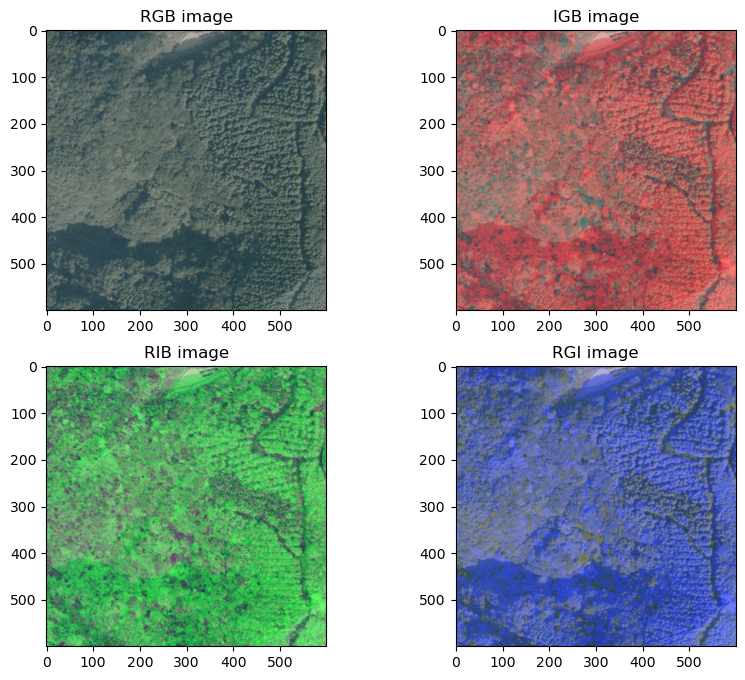

In [28]:
titles = [
    'RGB image',
    'IGB image',
    'RIB image',
    'RGI image'
]
arys = [
    img[800: 1400, : 600, :],
    igb_img[800: 1400, : 600, :],
    rib_img[800: 1400, : 600, :],
    rgi_img[800: 1400, : 600, :]
]

fig = plt.figure(figsize=(10, 8))
for idx, (title, ary) in enumerate(zip(titles, arys)):
    ax = fig.add_subplot(2, 2, idx + 1)
    ax.set_title(title)
    ax.imshow(ary)
plt.subplots_adjust(wspace=0.12)

In [38]:
OUT_FILE = IN_FILE.replace('proj.las', 'RGB_ORTHO.tif')
meta = red_dst.meta
meta['count'] = 3

with rasterio.open(OUT_FILE, 'w', **meta) as dst:
    for idx, _dst in enumerate([red_dst, green_dst, blue_dst]):
        dst.write(_dst.read(1), idx + 1)

In [29]:
intensity_dst.close()
red_dst.close()
green_dst.close()
blue_dst.close()